## Model Overview

In this project, we utilize Long Short-Term Memory (LSTM) networks to forecast energy consumption (`grid`) and solar generation (`solar`) for households. The analysis involves training LSTM models using sequential data, including weather and past consumption patterns, to predict energy demand for the next 24 hours.

### Models Trained
1. **Base LSTM Model**  
   **Description**: This model is trained on the original dataset without any modifications.  
   **Purpose**: Serves as a benchmark for evaluating the effectiveness of feature engineering and model tuning.

2. **LSTM with Enhanced Feature Set**  
   **Description**: This model is trained using the original dataset enriched with weather forecasts for the prediction window and additional encoded categorical features.  
   **Objective**: By incorporating more contextual information, this model aims to capture dependencies more effectively and improve forecasting accuracy.

### Why Use LSTMs?
LSTM networks are ideal for this task because they excel at modeling temporal dependencies in sequential data:
- **Input**: Sequential data for past `n` days, including consumption and weather variables.  
- **Prediction**: Forecast energy demand (`grid`) and solar generation (`solar`) for the next 24 hours.  
- **Features**: Incorporates both continuous variables (e.g., temperature, wind speed) and categorical variables (e.g., hour, day of the week).  

By leveraging their ability to learn long-term dependencies, LSTMs provide accurate forecasts based on historical and contextual data.


In [1]:
import numpy as np
from models import *

In [2]:
# Load data
#train_data = np.load("./data/lstm/train_data.npz")
#test_data = np.load("./data/lstm/test_data.npz")
train_data = np.load("E:/projects/energy forecast gnn lstm/data/lstm/train_data.npz")
test_data = np.load("E:/projects/energy forecast gnn lstm/data/lstm/test_data.npz")

X_train_past = train_data["X_train_past"]
X_train_weather_future = train_data["X_train_weather_future"]
Y_train = train_data["Y_train"]

In [3]:
# Extract shapes
input_past_shape = X_train_past.shape[1:]  # (168, 58)
input_future_shape = X_train_weather_future.shape[1:]  # (24, 9)
output_shape = Y_train.shape[1:]  # (24, 2)

In [4]:
forecast_steps = 24
num_targets = 2

model = build_lstm_model(
    input_past_shape=X_train_past.shape[1:],  # (168, 58)
    input_future_shape=X_train_weather_future.shape[1:],  # (24, 9)
    forecast_steps=forecast_steps,
    num_targets=num_targets
)


In [5]:
history = model.fit(
    [X_train_past, X_train_weather_future],  # Two inputs
    Y_train,                                # Target shape: (num_samples, 24, 2)
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
3882/3882 [==============================] - 429s 109ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 2/10
3882/3882 [==============================] - 431s 111ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/10
3882/3882 [==============================] - 382s 98ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/10
3882/3882 [==============================] - 379s 98ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/10
3882/3882 [==============================] - 377s 97ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/10
3882/3882 [==============================] - 375s 96ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/10
3882/3882 [==============================] - 370s 95ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 8/10
3882/3882 [==============================] - 368s 95ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/10
3882/3882 [==============================] - 370s 95ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/10
3882/3882 [==============================

In [6]:
X_test_past = test_data["X_test_past"]
X_test_weather_future = test_data["X_test_weather_future"]
Y_test = test_data["Y_test"]


predictions = model.predict([X_test_past, X_test_weather_future])  # Shape: (num_samples, 24, 2)


2203/2203 [==============================] - 64s 27ms/step


In [7]:
target_vars = ['grid', 'solar']

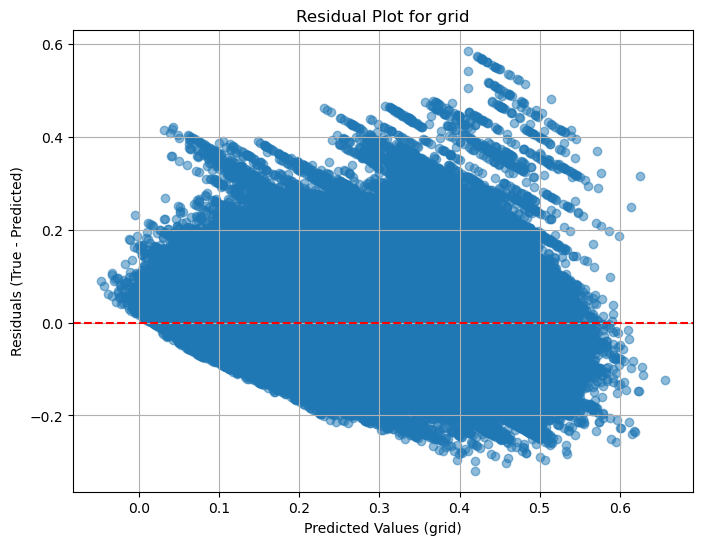

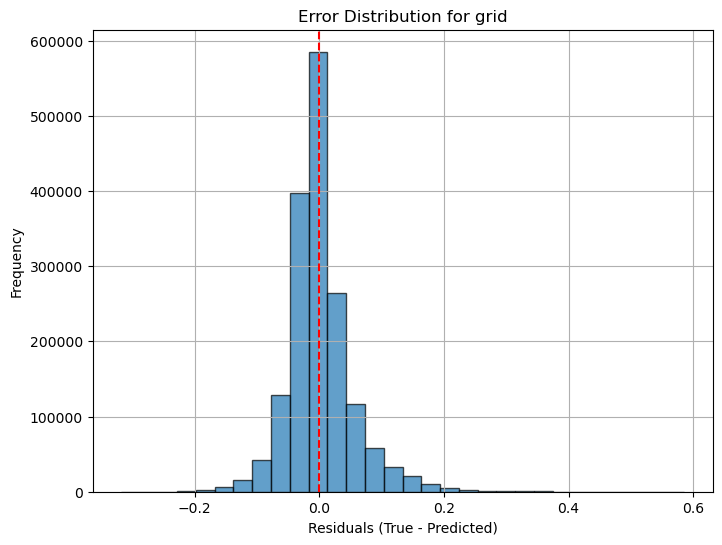

root mean square error: 0.052183590928610975


In [8]:
# Plot residuals for 'grid' (target_index=0)
plot_residuals(Y_test, predictions, target_index=0, target_name='grid')

# Plot residuals for 'solar' (target_index=1)
#plot_residuals(Y_test, predictions, target_index=1, target_name='solar')

# Plot error distribution for 'grid'
plot_error_distribution(Y_test, predictions, target_index=0, target_name='grid')

# Plot error distribution for 'solar'
#plot_error_distribution(Y_test, predictions, target_index=1, target_name='solar')

rmse=np.sqrt(np.sum((Y_test[:, :, 0].ravel()-predictions[:, :, 0].ravel())**2)/Y_test[:, :, 0].ravel().shape[0])
print('root mean square error: '+ str(rmse))


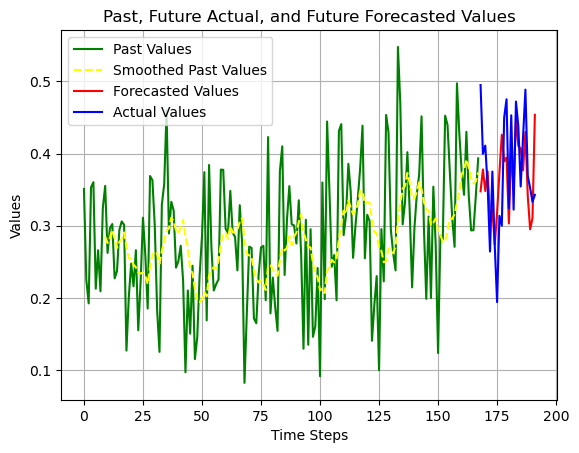

In [12]:
import numpy as np
#from models import moving_average

data_index= 258 # a random example

# Define time indices
time_past = np.arange(X_test_past.shape[1])  # Indices for past values
time_future = np.arange(X_test_past.shape[1], X_test_past.shape[1] + Y_test.shape[1])  # Indices for future values

# Smooth the past values
window_size = 10  # Adjust the window size for more or less smoothing
smoothed_past_values = moving_average(X_test_past[data_index, :, 1].ravel(), window_size)
smoothed_time_past = time_past[window_size - 1:]  # Adjust time indices for the smoothed curve



# Plot the past values
plt.plot(time_past, X_test_past[data_index, :, 1].ravel(), c='green', label='Past Values')


# Add the smoothed curve with a dotted line
plt.plot(smoothed_time_past, smoothed_past_values, c='yellow', linestyle='--', label='Smoothed Past Values')


# Plot the forecasted future values
plt.plot(time_future, predictions[data_index, :, 0].ravel(), c='red', label='Forecasted Values')

# Plot the actual future values
plt.plot(time_future, Y_test[data_index, :, 0].ravel(), c='blue', label='Actual Values')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Past, Future Actual, and Future Forecasted Values')
plt.legend()
plt.grid()
plt.show()

## Note: Bayesian Approach for LSTM Forecasting
In this notebook, we aim to extend the LSTM model to provide predictive uncertainty by using a Bayesian approach. This allows us to forecast a distribution of values instead of a single deterministic output. Here's a brief explanation of the methods used:

### 1. Monte Carlo Dropout (MC Dropout)
    A) What it is:
       MC Dropout is a simple and effective way to introduce stochasticity into the model. By applying dropout during both training and inference, we simulate multiple forward passes through a probabilistic model.
    B) How it works:
        Dropout randomly drops units in the network, forcing it to learn robust representations.
        During inference, dropout is typically turned off, but in MC Dropout, we keep it on, creating randomness in each forward pass.
    C) Output:
       Running the model multiple times on the same input yields a distribution of forecasts, from which we can compute:
        Mean forecast: The expected value of the predictions.
        Uncertainty (standard deviation): Captures the model's confidence in its predictions.
### 2. Generating Distributions of Forecasts
    A) During inference, we perform multiple stochastic forward passes on the same input.
    B) This generates a distribution of predictions, which allows us to calculate:
        Mean prediction for each time step.
        Confidence intervals (e.g., ±1 standard deviation) to visualize uncertainty.

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
def batch_predict(model, X_past, X_future, batch_size, num_passes):
    """
    Perform stochastic forward passes in batches to reduce memory usage.

    Parameters:
        model: Trained model with MC Dropout enabled.
        X_past: Past input data of shape (num_samples, time_steps, num_features).
        X_future: Future input data of shape (num_samples, forecast_steps, num_features).
        batch_size: Number of samples to process per batch.
        num_passes: Number of stochastic forward passes.

    Returns:
        all_predictions (numpy array): Predictions of shape 
                                        (num_passes, num_samples, forecast_steps, num_targets).
    """
    num_samples = X_past.shape[0]
    all_predictions = []

    for _ in range(num_passes):
        predictions = []
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_past = X_past[start_idx:end_idx]
            batch_future = X_future[start_idx:end_idx]
            pred = model.predict([batch_past, batch_future], verbose=0)
            predictions.append(pred)
        all_predictions.append(np.concatenate(predictions, axis=0))

    return np.array(all_predictions)



In [ ]:
from models import batch_predict

# Parameters
batch_size = 32  # Adjust based on available memory
num_passes = 100    # Reduce if needed

# Perform batch predictions
all_predictions = batch_predict(model, X_test_past, X_test_weather_future, batch_size, num_passes)

# Convert to numpy array for analysis
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)


In [82]:
std_predictions[data_index, :, 0]

array([5.9604645e-08, 2.9802322e-08, 5.9604645e-08, 0.0000000e+00,
       8.9406967e-08, 2.9802322e-08, 5.9604645e-08, 0.0000000e+00,
       5.9604645e-08, 2.9802322e-08, 5.9604645e-08, 0.0000000e+00,
       5.9604645e-08, 2.9802322e-08, 5.9604645e-08, 5.9604645e-08,
       2.9802322e-08, 5.9604645e-08, 8.9406967e-08, 5.9604645e-08,
       5.9604645e-08, 8.9406967e-08, 0.0000000e+00, 5.9604645e-08],
      dtype=float32)

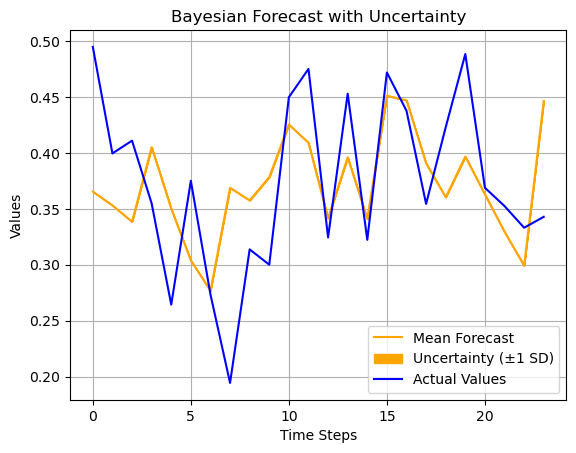

In [73]:
# Define time indices for future values
time_future =  np.arange(mean_predictions.shape[1])

# Plot mean forecast
plt.plot(time_future, mean_predictions[data_index, :, 0], c='orange', label='Mean Forecast')

# Plot confidence intervals (e.g., ±1 standard deviation)
plt.fill_between(
    time_future,
    mean_predictions[data_index, :, 0] - std_predictions[data_index, :, 0],
    mean_predictions[data_index, :, 0] + std_predictions[data_index, :, 0],
    color='orange',
    alpha=1,
    label='Uncertainty (±1 SD)'
)

# Plot actual values
plt.plot(time_future, Y_test[data_index, :, 0], c='blue', label='Actual Values')

# Add labels and legend
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Bayesian Forecast with Uncertainty')
plt.legend()
plt.grid()
plt.show()

In [68]:
import numpy as np
from models import build_mc_dropout_lstm
# Number of stochastic forward passes
num_passes = 100

# Store predictions
all_predictions = []

for _ in range(num_passes):
    pred = model.predict([X_test_past, X_test_weather_future], verbose=0)
    all_predictions.append(pred)

# Convert to numpy array for analysis
all_predictions = np.array(all_predictions)  # Shape: (num_passes, num_samples, forecast_steps, num_targets)

# Calculate mean and standard deviation of predictions
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)


MemoryError: Unable to allocate 2.56 GiB for an array with shape (70483, 168, 58) and data type float32